## Comparing to the kaggle data set

The kaggle data set is hosted here:  https://www.kaggle.com/gpreda/reddit-wallstreetsbets-posts

The key difference is that this appears to have been built by scraping new on a regular basis. This means that while it doesn't have the gaps that the pushshift data has, it is missing many entries. 

In [17]:


import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
kaggle_version = pd.read_csv('../Data/kaggle_wsb.csv')
pushshift_praw_version = pd.read_pickle('../Data/2021wsb.pkl')
kaggle_version.columns


Index(['title', 'score', 'id', 'url', 'comms_num', 'created', 'body',
       'timestamp'],
      dtype='object')

In [31]:
def date(created):
    # Converts the timestamp to UTC time
    return datetime.utcfromtimestamp(created)

pushshift_praw_version["created_datetime_utc"] = pushshift_praw_version["created_utc"].apply(date)

Plotting the time series:

<AxesSubplot:xlabel='timestamp', ylabel='score'>

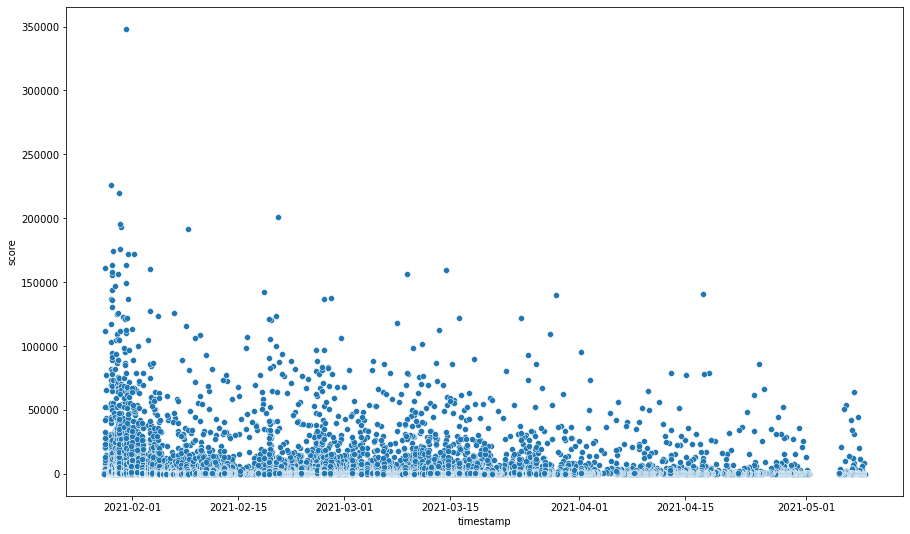

In [18]:

kaggle_version['timestamp'] = pd.to_datetime(kaggle_version['timestamp'])

fig, ax = plt.subplots(figsize=(15, 9))
sns.scatterplot(data = kaggle_version, x = "timestamp", y = "score")


There is still a mysterious gap... 

In [22]:
missing_ids = set(kaggle_version.id).difference(set(pushshift_praw_version.id))
print(len(missing_ids))
missing_rows = kaggle_version[kaggle_version.id.isin(missing_ids)][['title', 'id']]
missing_rows.head()

9124


,title,id
205,Where do we go from here and who is going to step up to help us?,l6j4r9
401,Buy NOK / Nokia in other places in case your broker (Robinhood etc.) blocked NOK at NYSE.,l6x0yn
403,Citadel is behind Robinhood's shutdown,l6x0yj
404,1Star Robinhoid,l6x0yi
504,get fricked lol,l6wzy9


In [33]:
# Submission ids in the pushshift_praw data set, from before the last time in the kaggle data set, but not in the kaggle data set, 

missing_ids = set(pushshift_praw_version[pushshift_praw_version['created_datetime_utc'] < datetime(2021, 2,1)].id).difference(set(kaggle_version.id))
print(len(missing_ids))
missing_rows = pushshift_praw_version[pushshift_praw_version.id.isin(missing_ids)][['title', 'id', 'created_datetime_utc']]
missing_rows

474208


,title,id,created_datetime_utc
0,Nio day🚀🚀,kom7tp,2021-01-01 23:55:39
1,Stop making “meta” posts about awards. You ain’t slick,kom59t,2021-01-01 23:51:49
2,Did I do something wrong (r/stocks),kom3zp,2021-01-01 23:49:52
3,Fuck r/stocks all my homies hate r/stocks,kom3oq,2021-01-01 23:49:26
4,$ACAM 🚀🚀🚀🚀 Go big or go home - I’ll be posting 2x / week until merger. This one is gonna get hot,kom1z8,2021-01-01 23:46:49
...,...,...,...
493482,Expr going to the moon,l8ze2i,2021-01-31 00:00:06
493483,Help me out here.,l8ze22,2021-01-31 00:00:06
493484,AMC discussion,l8ze0t,2021-01-31 00:00:04
493485,Long time lurker,l8ze0s,2021-01-31 00:00:04


In [34]:
kaggle_version[kaggle_version.id == 'kom59t']

,title,score,id,url,comms_num,created,body,timestamp


In [37]:
kaggle_version[kaggle_version.title.str.contains("Stop making “meta” posts about awards. You ain’t slick")]

,title,score,id,url,comms_num,created,body,timestamp


In [38]:
pushshift_praw_version[pushshift_praw_version.title.str.contains("Stop making “meta” posts about awards. You ain’t slick")]

,comment_limit,comment_sort,_reddit,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,...,preview,media_metadata,is_gallery,gallery_data,author_cakeday,collections,crosspost_parent_list,crosspost_parent,created_datetime,created_datetime_utc
1,2048,confidence,<praw.reddit.Reddit object at 0x000001D85CCED490>,None,wallstreetbets,[removed],NaN,False,None,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:01.609545109,2021-01-01 23:51:49


The code below gets the full data for the submissions in the kaggle data set, but not the pushshift praw.

It is probably best to just work with pushshift praw, and then wait for the pushshift mainters to add the backshift.

This is because the  missing data from the periods of time are missing in a systematic way, but the stuff missing from the 
kaggle data set is missing based on when the scraping happened.


In [ ]:
import praw


with open("API.env") as file:
    exec(file.read())

reddit = praw.Reddit(
  client_id = client_id,
  client_secret = client_secret,
  user_agent = user_agent
)


ids2 = [i if i.startswith('t3_') else f't3_{i}' for i in missing_ids]


praw_submissions = []
for submission in reddit.info(ids2): # Makes a single call to the PRAW API, much faster than doing them one by one.
    praw_submissions.append(extract_data(submission))

praw_df = pd.DataFrame(praw_submissions)
print(f"PRAW found {len(praw_df)} submissions.")

In [ ]:
praw_df